# Train & Test a Sentiment Model

- Load Data with a DataLoader
- Embeddings
- Model
- Train
- Test

In [1]:
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from pylab import rcParams
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch import nn, optim
from collections import defaultdict

In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Device

Train on CPU or GPU

In [3]:
print(f"Device: {device}")

Device: cpu


In [4]:
df = pd.read_pickle("train-sentiment.pkl")
df['label'] = pd.to_numeric(df["label"])
df.head(3)

,text,sentiment,label
292,Jan. 6 -- Ford is struggling in the face of sl...,negative,0
293,Pharmaceuticals group Orion Corp reported a fa...,negative,0
294,"However , the growth margin slowed down due to...",negative,0


# Tokenizer

In [5]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

# Test

In [6]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


In [7]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
  truncation=True,
)
print(encoding.keys())

dict_keys(['input_ids', 'attention_mask'])


In [8]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [9]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

# Get max Length

In [10]:
token_lens = []
for txt in tqdm(df.text):
    try:
        tokens = tokenizer.encode(txt, max_length=512, truncation=True)
        token_lens.append(len(tokens))
    except Exception as e:
        print(f"Exception: {e}")
        print(txt)

100%|██████████| 900/900 [00:00<00:00, 1460.65it/s]


In [11]:
print(max(token_lens))
print(min(token_lens))

155
4


In [12]:
MAX_LEN = 155

# Create Dataset

In [13]:
class GPReviewDataset(Dataset):
    def __init__(self, text, label, tokenizer, max_len):
        self.text = text
        self.label = label
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.text)
    def __getitem__(self, item):
        text = str(self.text[item])
        label = self.label[item]
        encoding = self.tokenizer.encode_plus(
          text,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt',
          truncation=True,
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long)
        }

# Split Data

- Train 90%
- Validate 5%
- Test 5%

In [14]:
df_train, df_test = train_test_split(
  df,
  test_size=0.1,
  random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

# DataLoader

In [15]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        text=df.text.to_numpy(),
        label=df.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
      )
    return DataLoader(
        ds,
        batch_size=batch_size,
        #num_workers=4
        num_workers=10
      )

In [16]:
BATCH_SIZE = 32
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [17]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['text', 'input_ids', 'attention_mask', 'targets'])

In [18]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([32, 155])
torch.Size([32, 155])
torch.Size([32])


# Load Bert Model

In [19]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

# Model Architecture

In [20]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)

class_names = [0,1,2]

In [21]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(type(input_ids))
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

#F.softmax(model(input_ids, attention_mask), dim=1)
torch.nn.functional.softmax(model(input_ids, attention_mask), dim=1)

<class 'torch.Tensor'>
torch.Size([32, 155])
torch.Size([32, 155])


tensor([[0.4684, 0.2040, 0.3276],
        [0.4261, 0.1262, 0.4477],
        [0.4773, 0.1200, 0.4027],
        [0.4921, 0.0665, 0.4415],
        [0.4396, 0.1412, 0.4192],
        [0.3275, 0.1661, 0.5064],
        [0.4153, 0.1537, 0.4310],
        [0.3828, 0.1715, 0.4457],
        [0.3850, 0.0959, 0.5191],
        [0.4839, 0.0994, 0.4167],
        [0.4613, 0.1933, 0.3454],
        [0.3594, 0.1214, 0.5192],
        [0.5083, 0.1186, 0.3731],
        [0.3075, 0.2254, 0.4671],
        [0.3244, 0.0819, 0.5938],
        [0.6041, 0.1128, 0.2830],
        [0.3619, 0.2034, 0.4347],
        [0.5291, 0.0889, 0.3820],
        [0.4050, 0.1417, 0.4533],
        [0.4833, 0.0927, 0.4240],
        [0.3621, 0.1496, 0.4882],
        [0.4539, 0.1765, 0.3696],
        [0.4223, 0.1809, 0.3968],
        [0.5876, 0.1433, 0.2691],
        [0.4234, 0.1909, 0.3857],
        [0.4053, 0.1344, 0.4603],
        [0.4075, 0.0717, 0.5208],
        [0.4782, 0.0840, 0.4378],
        [0.3928, 0.1067, 0.5005],
        [0.353

# Parameter

In [22]:
EPOCHS = 3
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [23]:
def train_epoch(
      model,
      data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      n_examples
    ):
    model = model.train()
    losses = []
    correct_predictions = 0
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_predictions.double() / n_examples, np.mean(losses)

In [24]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(
               input_ids=input_ids,
               attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
    return correct_predictions.double() / n_examples, np.mean(losses)

# Start training

In [25]:
#%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state-516781.bin')
        best_accuracy = val_acc

Epoch 1/3
----------
Train loss 0.5470380699978425 accuracy 0.7530864197530864
Val   loss 0.018852828070521355 accuracy 1.0

Epoch 2/3
----------
Train loss 0.10884886797374257 accuracy 0.9740740740740741
Val   loss 0.15259061474353075 accuracy 0.9333333333333333

Epoch 3/3
----------
Train loss 0.03464075010448981 accuracy 0.9888888888888889
Val   loss 0.05850444361567497 accuracy 0.9777777777777777



# Test Accuracy

In [26]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

0.9777777777777777

# Report or Matrix

In [27]:
def get_predictions(model, data_loader):
    model = model.eval()
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    with torch.no_grad():
        for d in data_loader:
            texts = d["text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(
              input_ids=input_ids,
              attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [28]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [29]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, labels=class_names))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        17
           1       1.00      1.00      1.00        12
           2       0.94      1.00      0.97        16

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



In [30]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.metrics import confusion_matrix

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

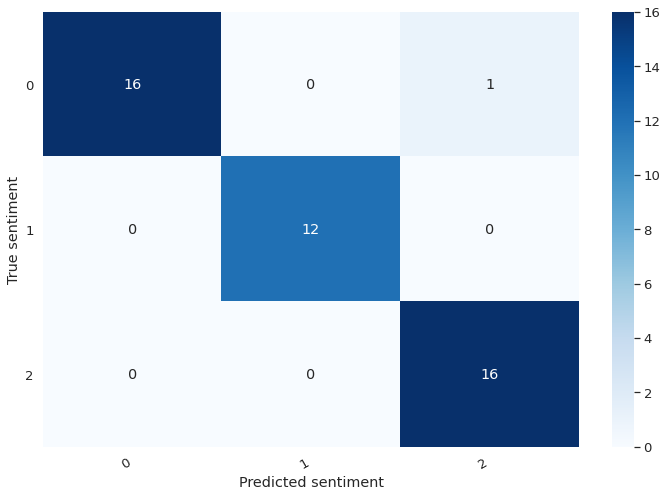

In [31]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

# Test Manual

In [32]:
review_text = "I love completing my todos! Best app ever!!!"

encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
  truncation=True,
)

input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I love completing my todos! Best app ever!!!
Sentiment  : 1
